In [2]:
import re
import csv
import io

def parse_mysql_dump_to_csv(dump_content):
    # Split the dump into lines
    lines = dump_content.split('\n')
    
    # Initialize variables to track current table
    current_table = None
    tables = {}
    
    # Regex patterns
    create_table_pattern = re.compile(r'CREATE TABLE `([^`]+)`')
    insert_into_pattern = re.compile(r'INSERT INTO `([^`]+)`')
    column_pattern = re.compile(r'`([^`]+)`')
    
    # Process each line
    for line in lines:
        line = line.strip()
        
        # Skip comments and empty lines
        if not line or line.startswith('--') or line.startswith('/*') or line.startswith('/*!'):
            continue
            
        # Check for CREATE TABLE
        create_match = create_table_pattern.match(line)
        if create_match:
            # Save previous table if exists
            if current_table:
                tables[current_table] = {
                    'columns': tables[current_table]['columns'],
                    'rows': tables[current_table]['rows']
                }
            
            # Start new table
            current_table = create_match.group(1)
            tables[current_table] = {
                'columns': [],
                'rows': []
            }
            continue
            
        # Check for INSERT INTO
        insert_match = insert_into_pattern.match(line)
        if insert_match and current_table:
            table_name = insert_match.group(1)
            if table_name == current_table:
                # Extract the VALUES part
                values_start = line.find('VALUES')
                if values_start != -1:
                    values_str = line[values_start+6:].strip()
                    
                    # Remove trailing semicolon
                    if values_str.endswith(';'):
                        values_str = values_str[:-1]
                    
                    # Process values
                    if values_str.startswith('(') and values_str.endswith(')'):
                        # Remove outer parentheses
                        values_str = values_str[1:-1]
                        
                        # Split into rows
                        rows = values_str.split('),(')
                        
                        for row_str in rows:
                            # Parse each row using csv reader
                            try:
                                # Replace escaped quotes for CSV compatibility
                                row_str_clean = row_str.replace("\\'", "''")
                                f = io.StringIO(row_str_clean)
                                reader = csv.reader(f, delimiter=',', quotechar="'")
                                row_values = next(reader)
                                tables[current_table]['rows'].append(row_values)
                            except:
                                # Fallback to manual parsing if CSV parsing fails
                                row_values = []
                                in_quotes = False
                                current_value = ''
                                
                                for char in row_str:
                                    if char == "'" and not in_quotes:
                                        in_quotes = True
                                    elif char == "'" and in_quotes:
                                        in_quotes = False
                                    elif char == ',' and not in_quotes:
                                        # Clean up value
                                        value = current_value.strip()
                                        if value.startswith("'") and value.endswith("'"):
                                            value = value[1:-1]
                                        row_values.append(value)
                                        current_value = ''
                                    else:
                                        current_value += char
                                
                                # Add the last value
                                value = current_value.strip()
                                if value.startswith("'") and value.endswith("'"):
                                    value = value[1:-1]
                                row_values.append(value)
                                
                                tables[current_table]['rows'].append(row_values)

            continue
            
        # Extract column names from CREATE TABLE
        if current_table and '`' in line:
            column_matches = column_pattern.findall(line)
            for col in column_matches:
                if col not in tables[current_table]['columns']:
                    tables[current_table]['columns'].append(col)
    
    # Save the last table
    if current_table:
        tables[current_table] = {
            'columns': tables[current_table]['columns'],
            'rows': tables[current_table]['rows']
        }
    
    # Write each table to a CSV file
    for table_name, data in tables.items():
        with open(f"{table_name}.csv", 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write header
            if data['columns']:
                writer.writerow(data['columns'])
            
            # Write rows
            for row in data['rows']:
                writer.writerow(row)
    
    return list(tables.keys())

# Read the dump file
with open(r"C:\Users\rakshithgowdahc\dist\crime_la-dumpfile.sql", 'r', encoding='utf-8') as f:
    dump_content = f.read()

# Process the dump file
tables = parse_mysql_dump_to_csv(dump_content)
print(f"Created CSV files for tables: {tables}")

Created CSV files for tables: ['location_t', 'officer_t', 'report_t', 'victim_t']


In [3]:
import shutil

# After the files are created, zip them:
import zipfile

with zipfile.ZipFile('csv_tables.zip', 'w') as zipf:
    for table_name in tables:
        zipf.write(f"{table_name}.csv")

print("Created csv_tables.zip")

# Now you can download csv_tables.zip using your notebook interface


Created csv_tables.zip


In [ ]:
import os
import zipfile

# Directory containing the CSV files
csv_dir = r"C:\Users\rakshithgowdahc\dist\csv_output"

# List of CSV files in that directory (or you can provide your own list)
tables = [f[:-4] for f in os.listdir(csv_dir) if f.endswith('.csv')]

zip_path = os.path.join(csv_dir, 'csv_tables.zip')

with zipfile.ZipFile(zip_path, 'w') as zipf:
    for table_name in tables:
        file_path = os.path.join(csv_dir, f"{table_name}.csv")
        zipf.write(file_path, arcname=f"{table_name}.csv")  # arcname strips the full path inside zip

print(f"Created {zip_path}")


#Question 1

Successfully loaded report_t.csv
Top 5 most frequent crimes: ['BATTERY - SIMPLE ASSAULT', 'BURGLARY FROM VEHICLE', 'THEFT PLAIN - PETTY ($950 & UN', 'KIDNAPPING', 'VANDALISM - FELONY ($400 & OVE']
Plot saved as 'weekly_crime_distribution.png'


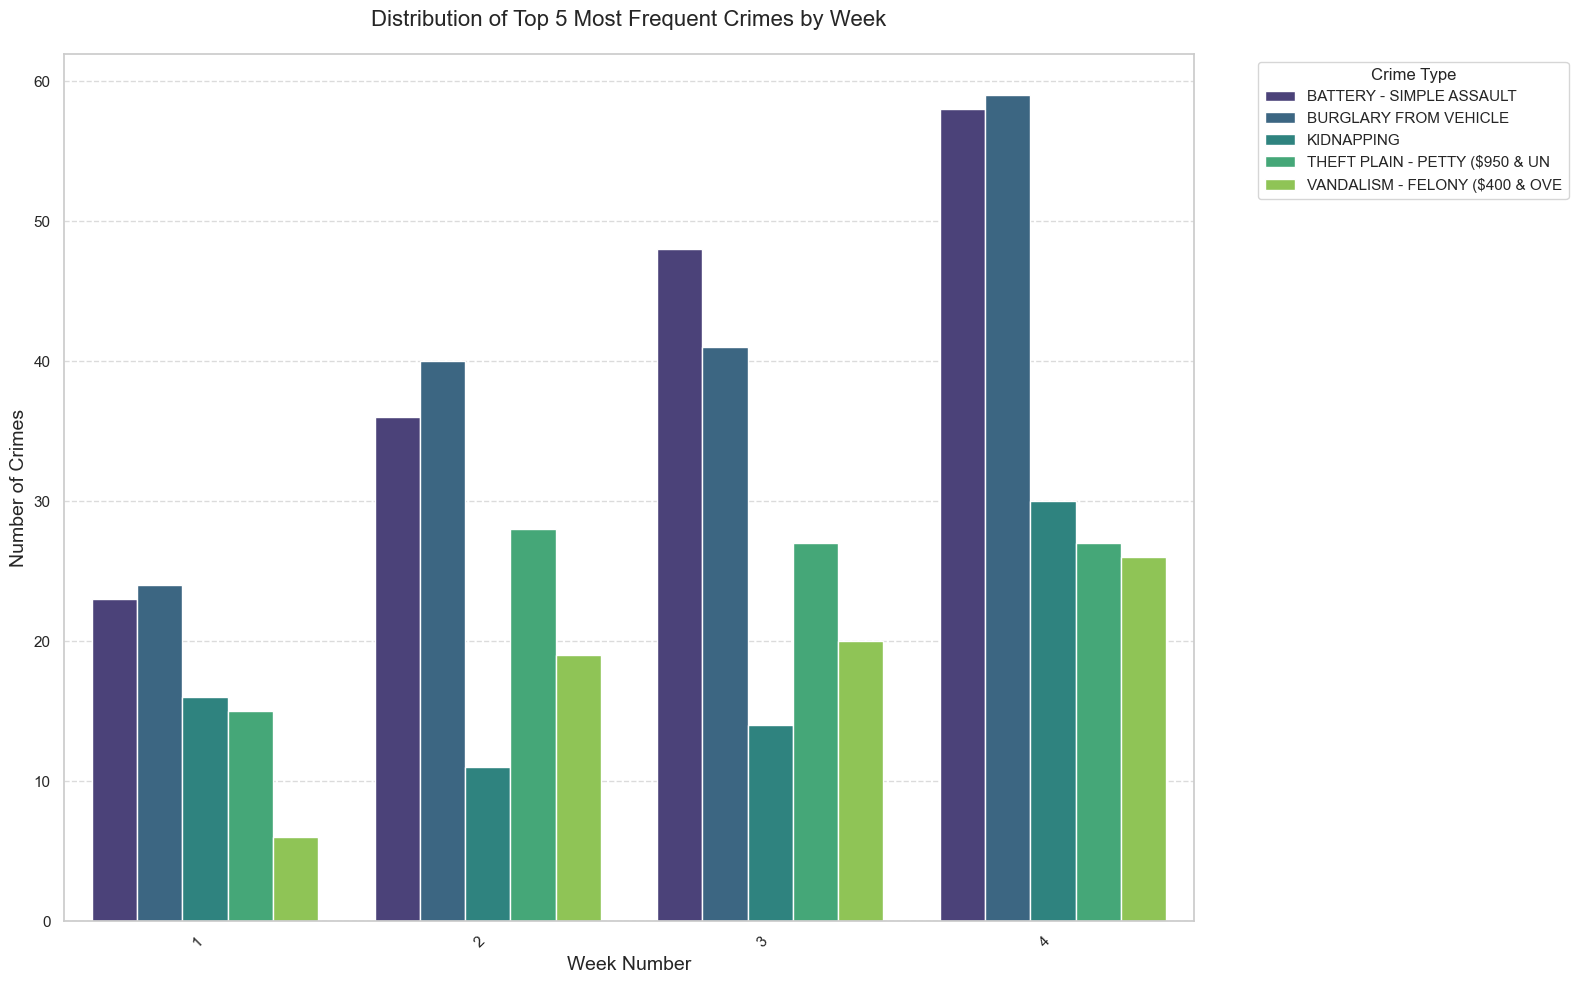


Summary Statistics:
                                count   mean        std   min    25%   50%  \
crime_type                                                                   
BATTERY - SIMPLE ASSAULT          4.0  41.25  15.129992  23.0  32.75  42.0   
BURGLARY FROM VEHICLE             4.0  41.00  14.306176  24.0  36.00  40.5   
KIDNAPPING                        4.0  17.75   8.421203  11.0  13.25  15.0   
THEFT PLAIN - PETTY ($950 & UN    4.0  24.25   6.184658  15.0  24.00  27.0   
VANDALISM - FELONY ($400 & OVE    4.0  17.75   8.421203   6.0  15.75  19.5   

                                  75%   max  
crime_type                                   
BATTERY - SIMPLE ASSAULT        50.50  58.0  
BURGLARY FROM VEHICLE           45.50  59.0  
KIDNAPPING                      19.50  30.0  
THEFT PLAIN - PETTY ($950 & UN  27.25  28.0  
VANDALISM - FELONY ($400 & OVE  21.50  26.0  

Weekly Crime Totals:
Top 5 weeks with highest crime counts:
week_number
4    200
3    150
2    134
1     84
N

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better visualization
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

# Load the crime report data
try:
    report_df = pd.read_csv('report_t.csv')
    print("Successfully loaded report_t.csv")
except FileNotFoundError:
    print("Error: report_t.csv not found. Make sure you've converted the MySQL dump to CSV files first.")
    exit()

# Check if required columns exist
required_columns = ['week_number', 'crime_type']
if not all(col in report_df.columns for col in required_columns):
    print(f"Error: Missing required columns. Available columns: {report_df.columns.tolist()}")
    exit()

# Clean the data - remove rows with missing values in key columns
report_df = report_df.dropna(subset=['week_number', 'crime_type'])

# Find the top 5 most frequent crime types overall
top_crimes = report_df['crime_type'].value_counts().nlargest(5).index.tolist()
print(f"Top 5 most frequent crimes: {top_crimes}")

# Filter data to include only these top crimes
filtered_df = report_df[report_df['crime_type'].isin(top_crimes)]

# Group by week number and crime type, then count occurrences
weekly_crime_counts = filtered_df.groupby(['week_number', 'crime_type']).size().reset_index(name='count')

# Create the grouped bar chart
plt.figure(figsize=(16, 10))
ax = sns.barplot(
    x='week_number', 
    y='count', 
    hue='crime_type', 
    data=weekly_crime_counts,
    palette='viridis'
)

# Customize the plot
plt.title('Distribution of Top 5 Most Frequent Crimes by Week', fontsize=16, pad=20)
plt.xlabel('Week Number', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Save the plot
plt.savefig('weekly_crime_distribution.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'weekly_crime_distribution.png'")

# Show the plot
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(weekly_crime_counts.groupby('crime_type')['count'].describe())

# Print weekly totals
print("\nWeekly Crime Totals:")
weekly_totals = weekly_crime_counts.groupby('week_number')['count'].sum().sort_values(ascending=False)
print(f"Top 5 weeks with highest crime counts:\n{weekly_totals.head()}")

Successfully loaded all CSV files


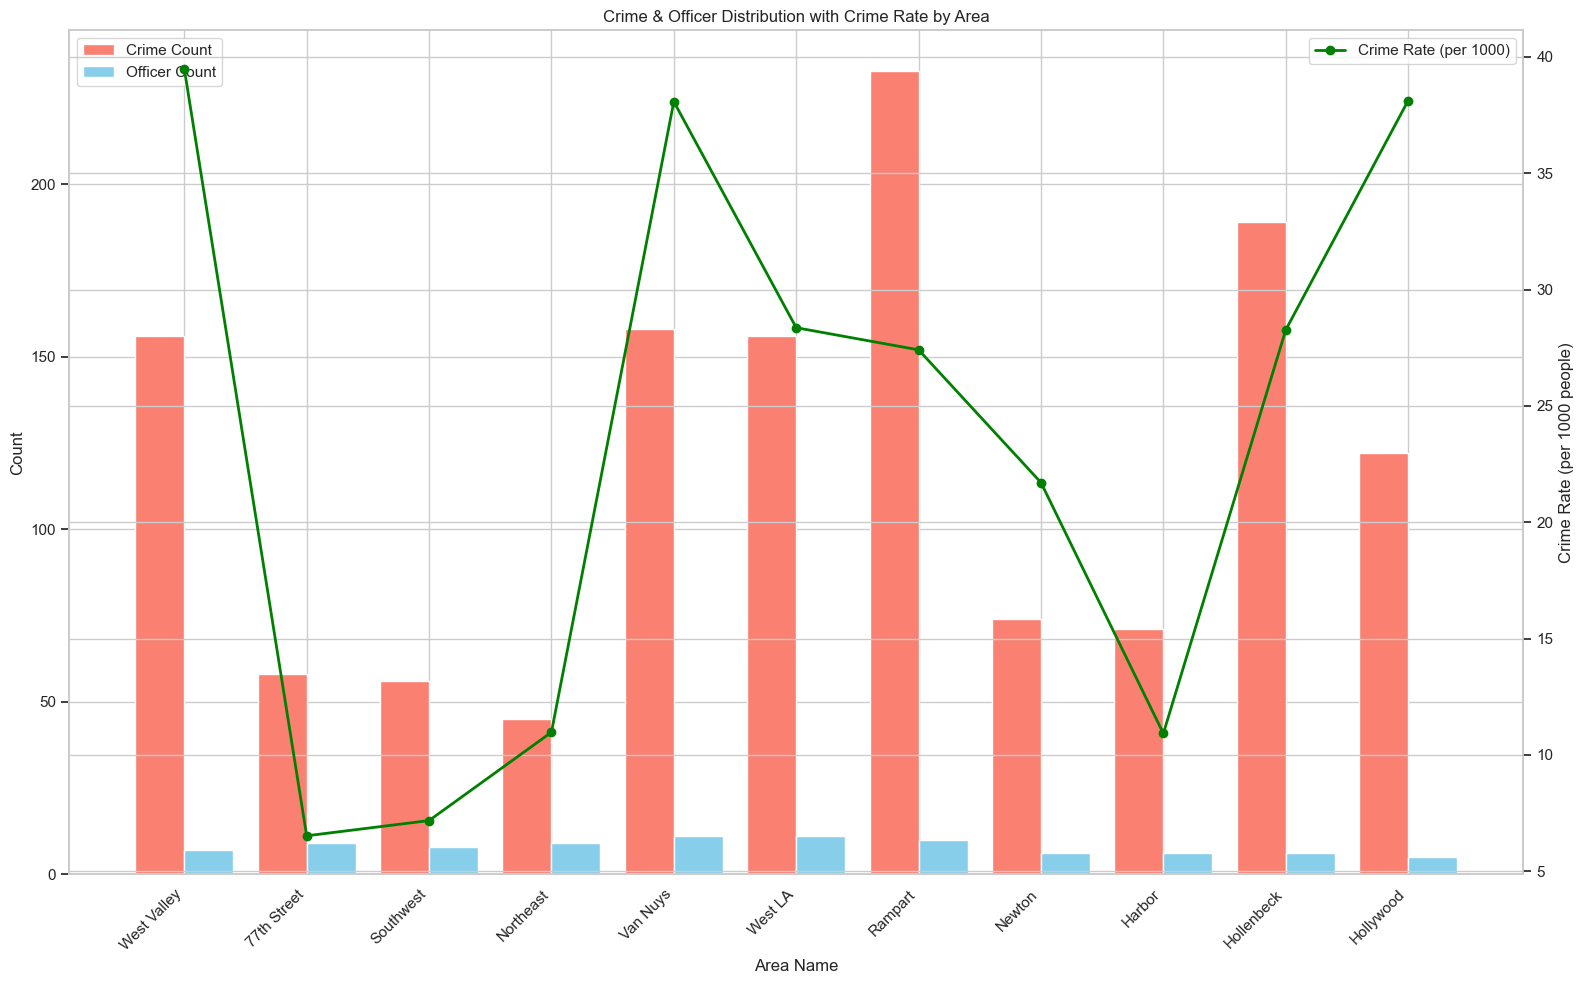

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better visualization
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Load the data
try:
    location_df = pd.read_csv('location_t.csv')
    officer_df = pd.read_csv('officer_t.csv')
    report_df = pd.read_csv('report_t.csv')
    print("Successfully loaded all CSV files")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure you've converted the MySQL dump to CSV files first.")
    exit()

# Check if required columns exist
required_columns = {
    'location': ['area_code', 'area_name', 'population_density'],
    'officer': ['officer_code', 'precinct_code'],
    'report': ['area_code', 'officer_code']
}

for df_name, cols in required_columns.items():
    df = locals()[f"{df_name}_df"]
    missing_cols = [col for col in cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Missing columns in {df_name}_df: {missing_cols}")
        exit()

# Calculate crime count per area
crime_count_by_area = report_df.groupby('area_code').size().reset_index(name='crime_count')

# Calculate officer count per area (based on unique officers assigned to reports in that area)
officer_count_by_area = report_df.groupby('area_code')['officer_code'].nunique().reset_index(name='officer_count')

# Merge with location data
merged_df = pd.merge(location_df, crime_count_by_area, on='area_code', how='left')
merged_df = pd.merge(merged_df, officer_count_by_area, on='area_code', how='left')

# Fill NaN values with 0 (for areas with no crimes or officers)
merged_df['crime_count'] = merged_df['crime_count'].fillna(0).astype(int)
merged_df['officer_count'] = merged_df['officer_count'].fillna(0).astype(int)

# Calculate crime rate (crimes per 1000 people)
merged_df['crime_rate'] = (merged_df['crime_count'] / merged_df['population_density']) * 1000

# Sort by area_code for better visualization
merged_df = merged_df.sort_values('area_code')

# Create the figure and subplots
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()

# Bar chart for crime count and officer count
bar_width = 0.4
indices = np.arange(len(merged_df))

ax1.bar(indices - bar_width/2, merged_df['crime_count'], bar_width, label='Crime Count', color='salmon')
ax1.bar(indices + bar_width/2, merged_df['officer_count'], bar_width, label='Officer Count', color='skyblue')

# Line chart for crime rate
ax2.plot(indices, merged_df['crime_rate'], label='Crime Rate (per 1000)', color='green', marker='o', linewidth=2)

# Set x-axis labels
ax1.set_xticks(indices)
ax1.set_xticklabels(merged_df['area_name'], rotation=45, ha='right')

# Labels and title
ax1.set_xlabel('Area Name')
ax1.set_ylabel('Count')
ax2.set_ylabel('Crime Rate (per 1000 people)')
plt.title('Crime & Officer Distribution with Crime Rate by Area')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Layout adjustment
plt.tight_layout()

# Show plot
plt.show()


Successfully loaded all CSV files
Plot saved as 'area_crime_comparison.png'


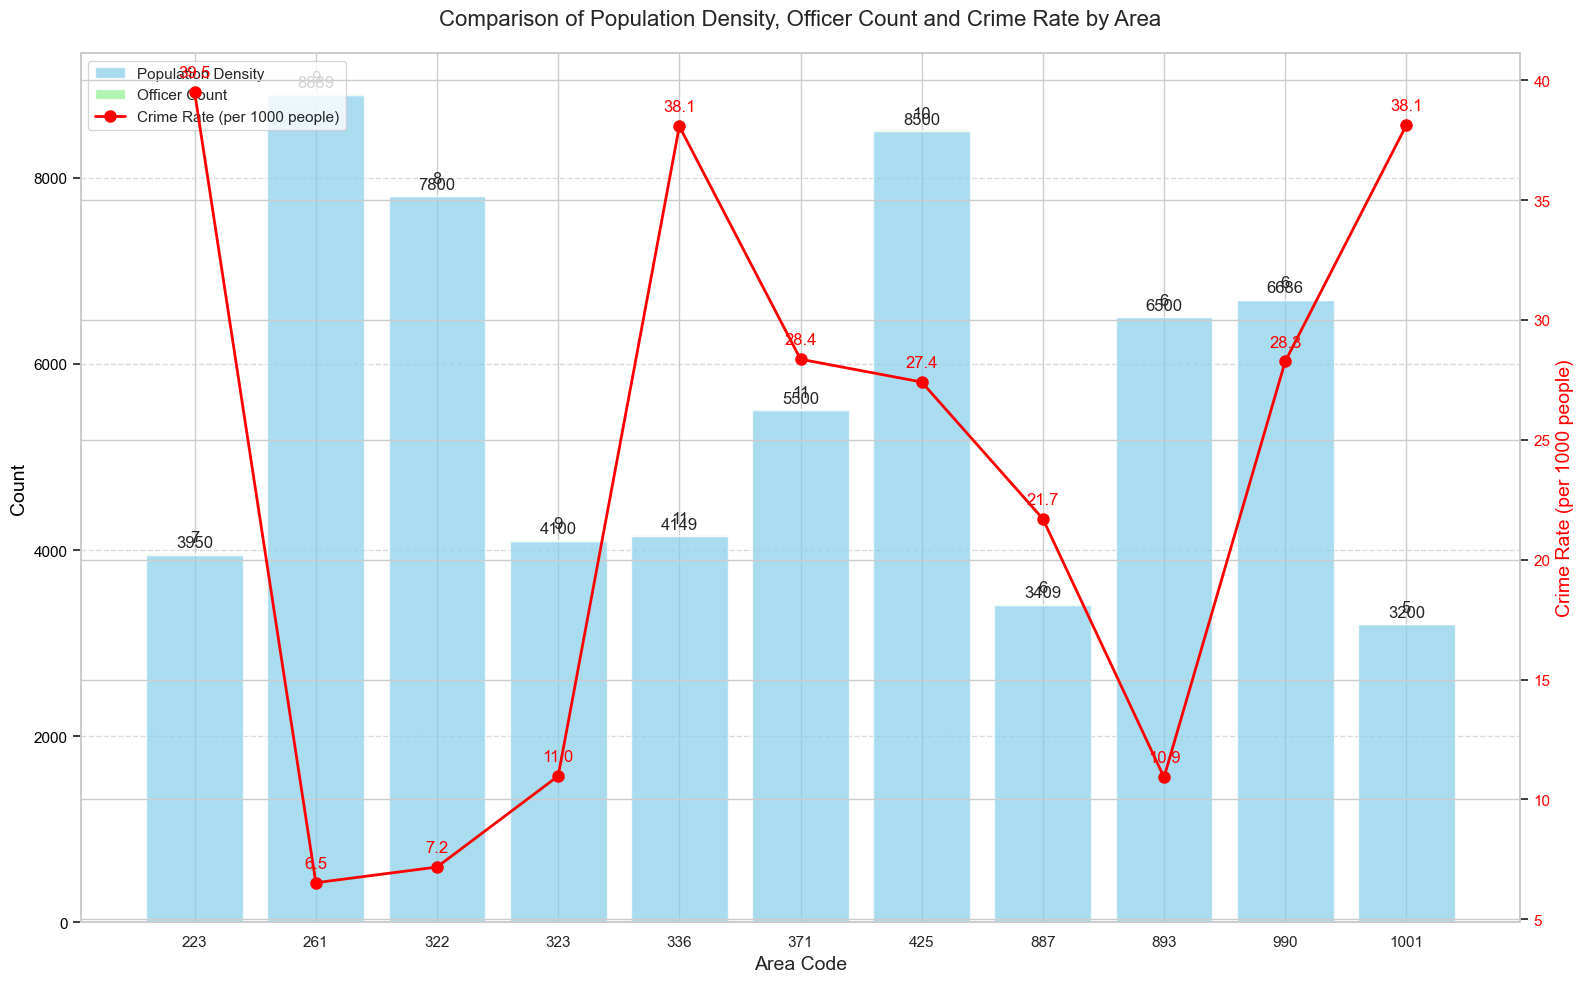


Summary Statistics by Area:
 area_code   area_name  population_density  officer_count  crime_count  crime_rate
       223 West Valley                3950              7          156   39.493671
       261 77th Street                8889              9           58    6.524918
       322   Southwest                7800              8           56    7.179487
       323   Northeast                4100              9           45   10.975610
       336    Van Nuys                4149             11          158   38.081465
       371     West LA                5500             11          156   28.363636
       425     Rampart                8500             10          233   27.411765
       887      Newton                3409              6           74   21.707246
       893      Harbor                6500              6           71   10.923077
       990  Hollenbeck                6686              6          189   28.268023
      1001   Hollywood                3200              5 

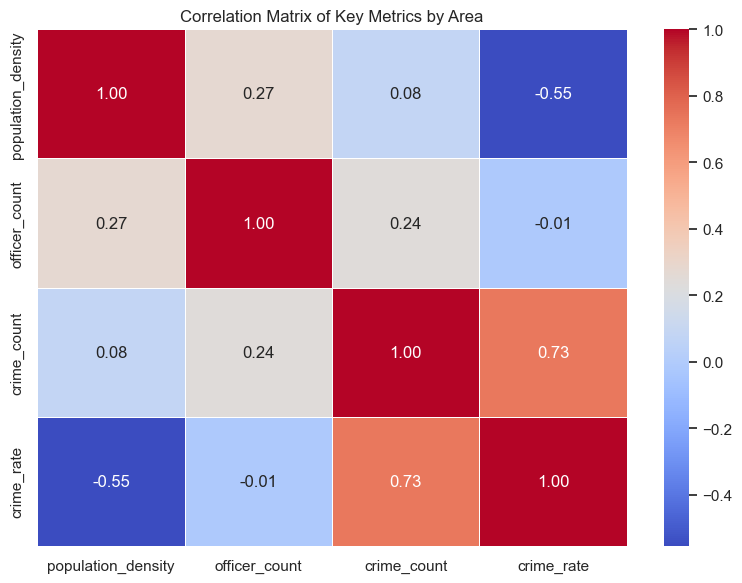

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better visualization
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Load the data
try:
    location_df = pd.read_csv('location_t.csv')
    officer_df = pd.read_csv('officer_t.csv')
    report_df = pd.read_csv('report_t.csv')
    print("Successfully loaded all CSV files")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure you've converted the MySQL dump to CSV files first.")
    exit()

# Check if required columns exist
required_columns = {
    'location': ['area_code', 'area_name', 'population_density'],
    'officer': ['officer_code', 'precinct_code'],
    'report': ['area_code', 'officer_code']
}

for df_name, cols in required_columns.items():
    df = locals()[f"{df_name}_df"]
    missing_cols = [col for col in cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Missing columns in {df_name}_df: {missing_cols}")
        exit()

# Calculate crime count per area
crime_count_by_area = report_df.groupby('area_code').size().reset_index(name='crime_count')

# Calculate officer count per area (using officer_code in reports)
officer_count_by_area = report_df.groupby('area_code')['officer_code'].nunique().reset_index(name='officer_count')

# Merge with location data
merged_df = pd.merge(location_df, crime_count_by_area, on='area_code', how='left')
merged_df = pd.merge(merged_df, officer_count_by_area, on='area_code', how='left')

# Fill NaN values with 0 (for areas with no crimes or officers)
merged_df['crime_count'] = merged_df['crime_count'].fillna(0).astype(int)
merged_df['officer_count'] = merged_df['officer_count'].fillna(0).astype(int)

# Calculate crime rate (crimes per 1000 people)
merged_df['crime_rate'] = (merged_df['crime_count'] / merged_df['population_density']) * 1000

# Sort by area_code for better visualization
merged_df = merged_df.sort_values('area_code')

# Create the figure and subplots
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis

# Plot population density as bars
bars1 = ax1.bar(merged_df['area_code'].astype(str), merged_df['population_density'], 
                 color='skyblue', alpha=0.7, label='Population Density')

# Plot officer count as bars
bars2 = ax1.bar(merged_df['area_code'].astype(str), merged_df['officer_count'], 
                 color='lightgreen', alpha=0.7, label='Officer Count', 
                 bottom=merged_df['population_density'])

# Plot crime rate as a line on the secondary y-axis
line = ax2.plot(merged_df['area_code'].astype(str), merged_df['crime_rate'], 
               color='red', marker='o', markersize=8, linewidth=2, label='Crime Rate (per 1000 people)')

# Customize the plot
ax1.set_xlabel('Area Code', fontsize=14)
ax1.set_ylabel('Count', fontsize=14, color='black')
ax2.set_ylabel('Crime Rate (per 1000 people)', fontsize=14, color='red')
ax1.set_title('Comparison of Population Density, Officer Count and Crime Rate by Area', 
                fontsize=16, pad=20)

# Set tick colors
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='red')

# Add grid
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add data labels on bars
for i, (density, officers) in enumerate(zip(merged_df['population_density'], merged_df['officer_count'])):
    ax1.text(i, density + 50, f'{density}', ha='center', va='bottom')
    ax1.text(i, density + officers + 100, f'{officers}', ha='center', va='bottom')

# Add data labels on the line
for i, rate in enumerate(merged_df['crime_rate']):
    ax2.text(i, rate + 0.5, f'{rate:.1f}', ha='center', va='bottom', color='red')

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('area_crime_comparison.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'area_crime_comparison.png'")

# Show the plot
plt.show()

# Print summary statistics
print("\nSummary Statistics by Area:")
print(merged_df[['area_code', 'area_name', 'population_density', 'officer_count', 'crime_count', 'crime_rate']].to_string(index=False))

# Find correlations
print("\nCorrelation Matrix:")
correlation_df = merged_df[['population_density', 'officer_count', 'crime_count', 'crime_rate']]
correlation_matrix = correlation_df.corr()
print(correlation_matrix.to_string())

# Optional: Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Key Metrics by Area')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("Correlation matrix plot saved as 'correlation_matrix.png'")
plt.show()

In [9]:
import pandas as pd

# Load the CSV files
victim_df = pd.read_csv('victim_t.csv')
location_df = pd.read_csv('location_t.csv')
officer_df = pd.read_csv('officer_t.csv')
repot_df = pd.read_csv('report_t.csv')

# Print headers for each file
print("Headers in victim_t.csv:")
print(victim_df.columns.tolist())

print("\nHeaders in location_t.csv:")
print(location_df.columns.tolist())

print("\nHeaders in officer_t.csv:")
print(officer_df.columns.tolist())

print("Headers in report_t.csv:")
print(repot_df.columns.tolist())


Headers in victim_t.csv:
['victim_code', 'victim_name', 'victim_sex', 'victim_age', 'was_victim_alone', 'is_victim_insured', 'victim_t']

Headers in location_t.csv:
['area_code', 'area_name', 'cctv_count', 'population_density', 'rounds_per_day', 'location_t', 'officer_t']

Headers in officer_t.csv:
['officer_code', 'officer_name', 'officer_sex', 'avg_close_days', 'precinct_code', 'officer_t', 'report_t']
Headers in report_t.csv:
['report_no', 'incident_time', 'complaint_type', 'cctv_flag', 'area_code', 'victim_code', 'offender_code', 'offender_name', 'offender_sex', 'offender_age', 'repeated_offender', 'no_of_offences', 'offender_relation', 'officer_code', 'case_status_code', 'case_status_desc', 'crime_code', 'crime_type', 'weapon_code', 'weapon_desc', 'week_number', 'report_t', 'victim_t']


C:\Users\rakshithgowdahc\AppData\Local\Temp\ipykernel_2556\2429571667.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("report_t.csv", parse_dates=['incident_time'])
C:\Users\rakshithgowdahc\AppData\Local\Temp\ipykernel_2556\2429571667.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


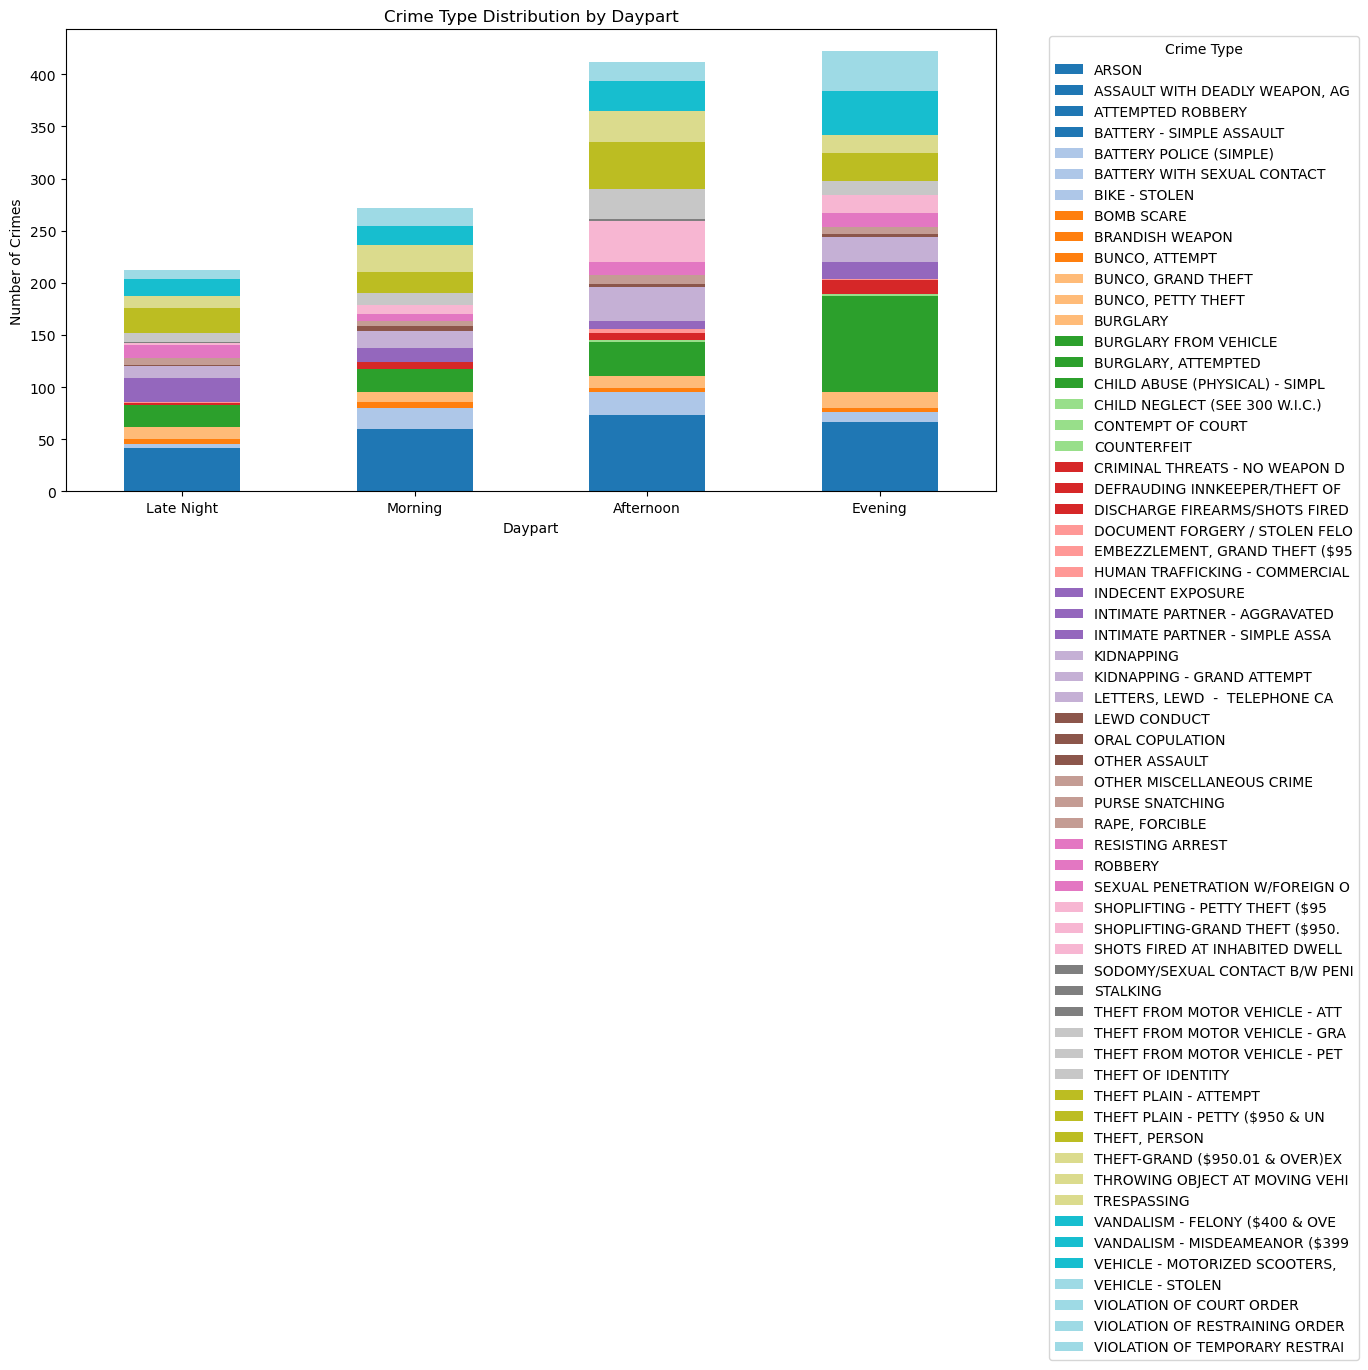

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("report_t.csv", parse_dates=['incident_time'])

# Define a function to map times to dayparts
def get_daypart(time):
    hour = time.hour
    if 0 <= hour < 6:
        return 'Late Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Apply the function
df['incident_time'] = pd.to_datetime(df['incident_time'])
df['daypart'] = df['incident_time'].apply(get_daypart)

# Group by daypart and crime type
grouped = df.groupby(['daypart', 'crime_type']).size().unstack(fill_value=0)

# Reorder dayparts for logical flow
daypart_order = ['Late Night', 'Morning', 'Afternoon', 'Evening']
grouped = grouped.reindex(daypart_order)

# Plotting
grouped.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title("Crime Type Distribution by Daypart")
plt.xlabel("Daypart")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=0)
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\rakshithgowdahc\AppData\Local\Temp\ipykernel_2556\3063570818.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  report_df = pd.read_csv("report_t.csv", parse_dates=['incident_time'])


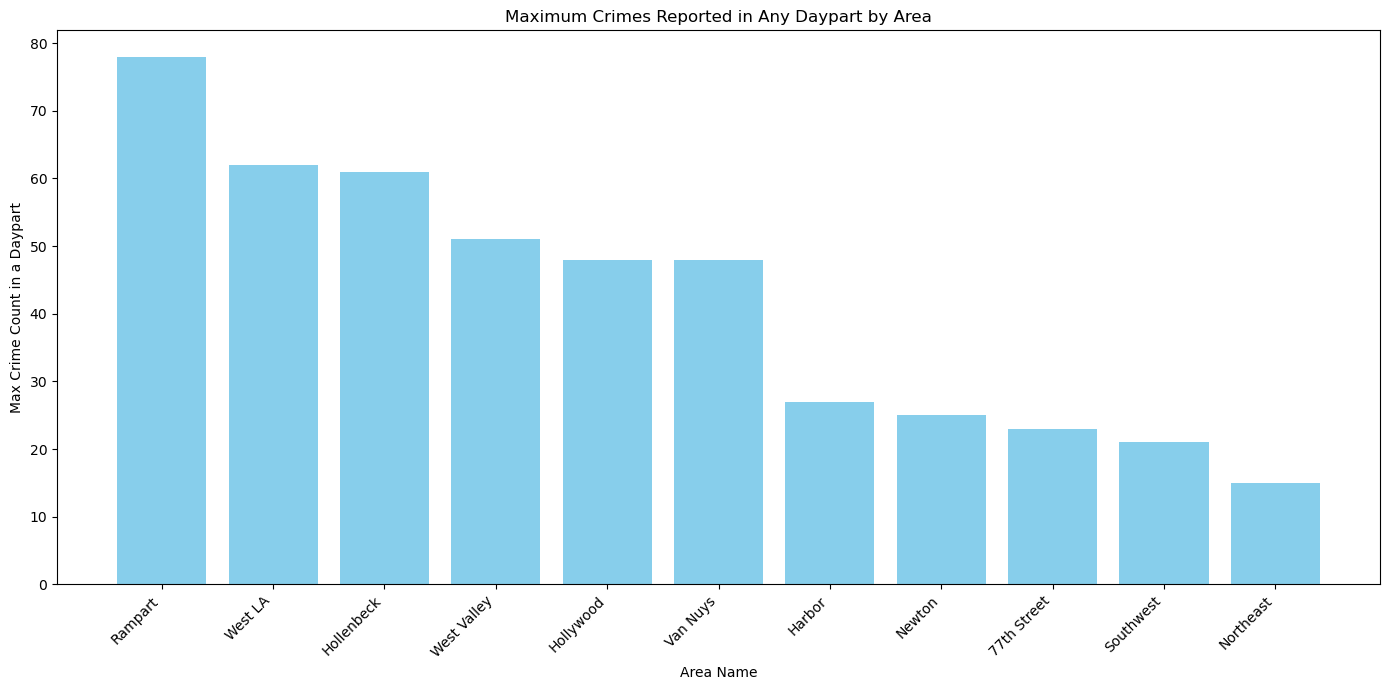

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
report_df = pd.read_csv("report_t.csv", parse_dates=['incident_time'])
location_df = pd.read_csv("location_t.csv")

# Merge report with location to get area_name
merged_df = report_df.merge(location_df[['area_code', 'area_name']], on='area_code', how='left')

# Define function to get daypart from incident_time
def get_daypart(time):
    hour = time.hour
    if 0 <= hour < 6:
        return 'Late Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Apply daypart categorization
merged_df['incident_time'] = pd.to_datetime(merged_df['incident_time'])
merged_df['daypart'] = merged_df['incident_time'].apply(get_daypart)

# Group by area_name and daypart to count crimes
grouped = merged_df.groupby(['area_name', 'daypart']).size().reset_index(name='crime_count')

# For each area, find the max crime count across dayparts
max_crimes = grouped.groupby('area_name')['crime_count'].max().reset_index()

# Sort areas by max crimes for better visualization
max_crimes = max_crimes.sort_values('crime_count', ascending=False)

# Plot bar chart
plt.figure(figsize=(14, 7))
plt.bar(max_crimes['area_name'], max_crimes['crime_count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Area Name')
plt.ylabel('Max Crime Count in a Daypart')
plt.title('Maximum Crimes Reported in Any Daypart by Area')
plt.tight_layout()
plt.show()


C:\Users\rakshithgowdahc\AppData\Local\Temp\ipykernel_2556\1732936548.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  report_df = pd.read_csv("report_t.csv", parse_dates=['incident_time'])


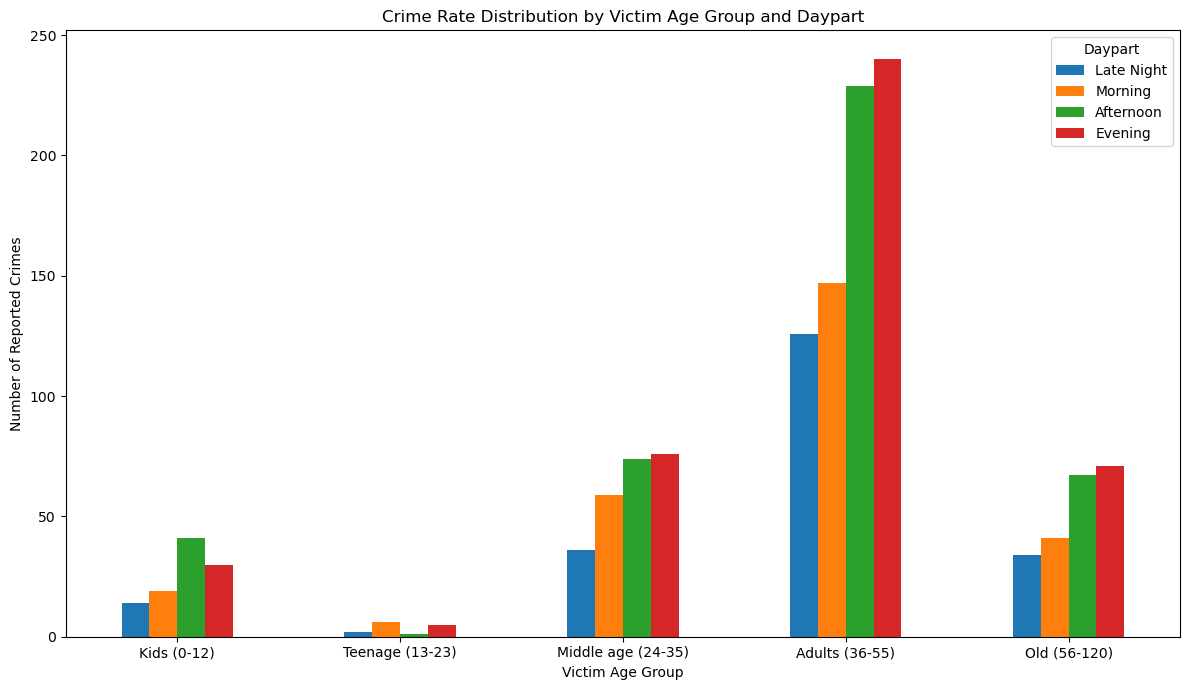

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
report_df = pd.read_csv("report_t.csv", parse_dates=['incident_time'])
victim_df = pd.read_csv("victim_t.csv")

# Merge on victim_code to get victim ages
merged_df = report_df.merge(victim_df[['victim_code', 'victim_age']], on='victim_code', how='left')

# Define age categories
def age_category(age):
    if age <= 12:
        return 'Kids (0-12)'
    elif age <= 23:
        return 'Teenage (13-23)'
    elif age <= 35:
        return 'Middle age (24-35)'
    elif age <= 55:
        return 'Adults (36-55)'
    else:
        return 'Old (56-120)'

merged_df['age_category'] = merged_df['victim_age'].apply(age_category)

# Define dayparts based on incident time
def get_daypart(time):
    hour = time.hour
    if 0 <= hour < 6:
        return 'Late Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

merged_df['incident_time'] = pd.to_datetime(merged_df['incident_time'])
merged_df['daypart'] = merged_df['incident_time'].apply(get_daypart)

# Group by age_category and daypart and count crimes
grouped = merged_df.groupby(['age_category', 'daypart']).size().unstack(fill_value=0)

# Reorder rows and columns for better plotting
age_order = ['Kids (0-12)', 'Teenage (13-23)', 'Middle age (24-35)', 'Adults (36-55)', 'Old (56-120)']
daypart_order = ['Late Night', 'Morning', 'Afternoon', 'Evening']

grouped = grouped.reindex(age_order)
grouped = grouped[daypart_order]

# Plot grouped bar chart
grouped.plot(kind='bar', figsize=(12,7))
plt.title('Crime Rate Distribution by Victim Age Group and Daypart')
plt.xlabel('Victim Age Group')
plt.ylabel('Number of Reported Crimes')
plt.xticks(rotation=0)
plt.legend(title='Daypart')
plt.tight_layout()
plt.show()


C:\Users\rakshithgowdahc\AppData\Local\Temp\ipykernel_2556\4294421792.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  report_df['incident_time'] = pd.to_datetime(report_df['incident_time'])
C:\Users\rakshithgowdahc\AppData\Local\Temp\ipykernel_2556\4294421792.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  case_status_by_day = report_df.groupby(['day_of_week', 'case_status_desc']).size().reset_index(name='count')


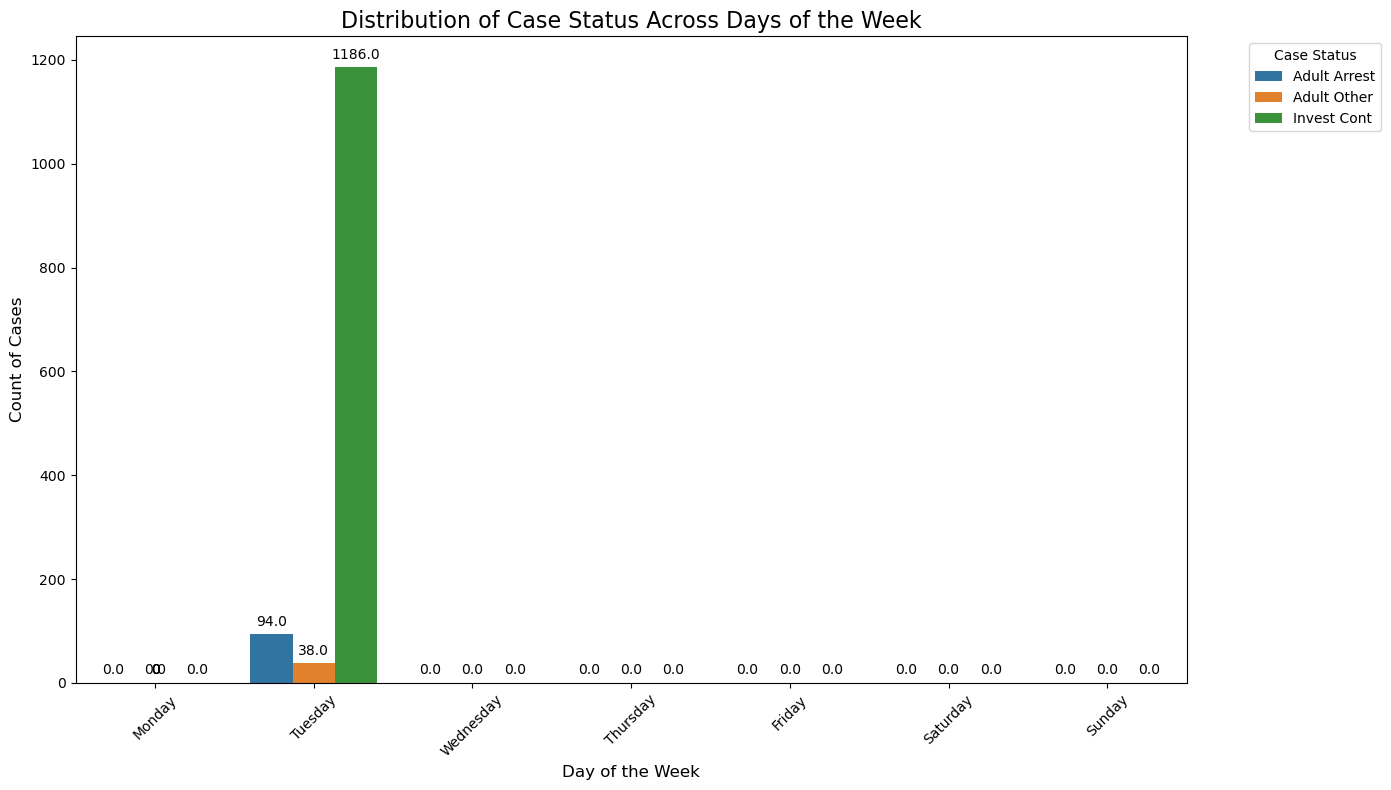

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the report_t.csv file
report_df = pd.read_csv('report_t.csv')

# Convert incident_time to datetime
report_df['incident_time'] = pd.to_datetime(report_df['incident_time'])

# Extract day of the week from incident_time
report_df['day_of_week'] = report_df['incident_time'].dt.day_name()

# Define the order of days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
report_df['day_of_week'] = pd.Categorical(report_df['day_of_week'], categories=days_order, ordered=True)

# Group by day_of_week and case_status_desc, then count occurrences
case_status_by_day = report_df.groupby(['day_of_week', 'case_status_desc']).size().reset_index(name='count')

# Create a grouped bar chart
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='day_of_week', y='count', hue='case_status_desc', data=case_status_by_day)
plt.title('Distribution of Case Status Across Days of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Count of Cases', fontsize=12)
plt.legend(title='Case Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

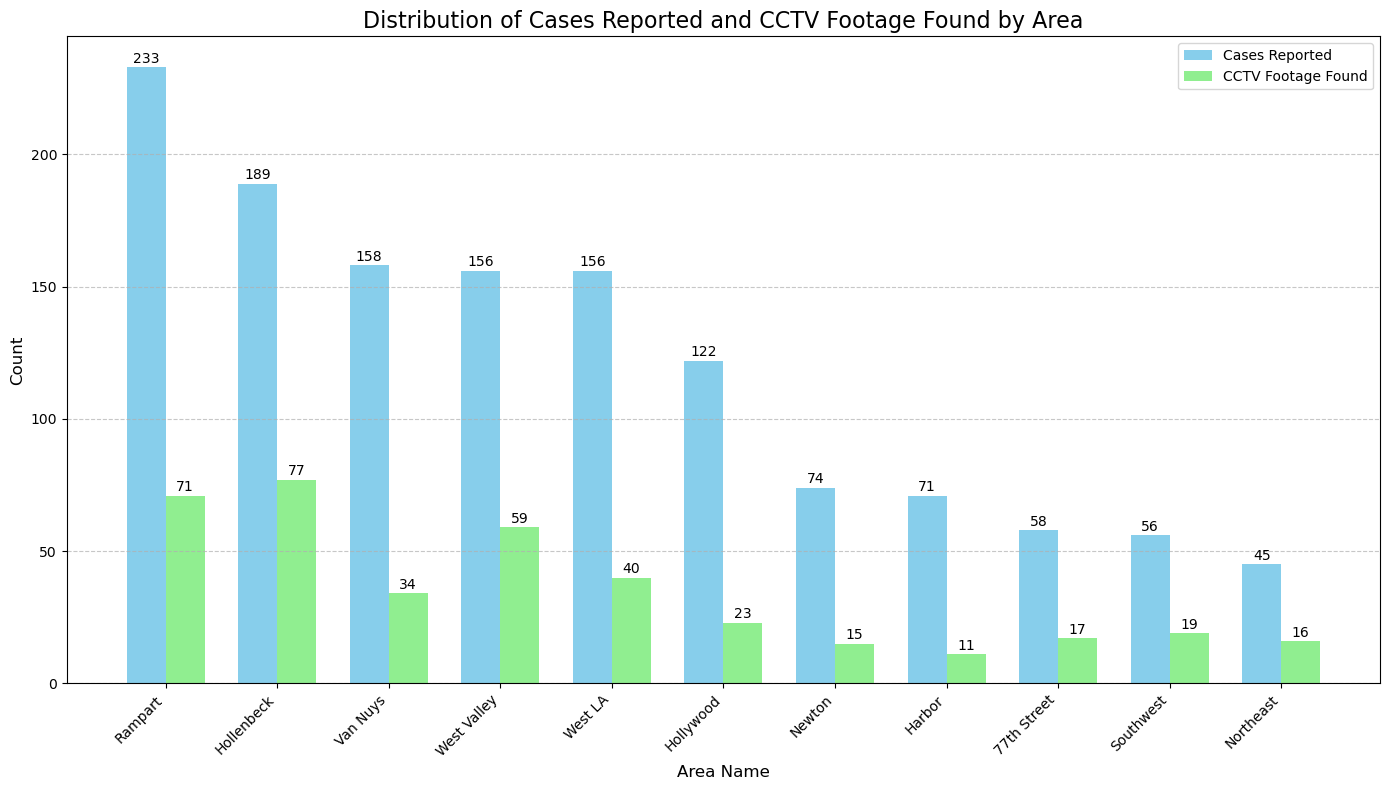

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the required data files
location_df = pd.read_csv('location_t.csv')
report_df = pd.read_csv('report_t.csv')

# Calculate total cases reported per area
cases_per_area = report_df.groupby('area_code').size().reset_index(name='cases_reported')

# Calculate cases with CCTV footage found per area
cctv_cases = report_df[report_df['cctv_flag'] == True].groupby('area_code').size().reset_index(name='cctv_footage_found')

# Merge with location data to get area names
merged_df = pd.merge(location_df[['area_code', 'area_name']], cases_per_area, on='area_code', how='left')
merged_df = pd.merge(merged_df, cctv_cases, on='area_code', how='left')

# Fill NaN values with 0 (areas with no CCTV footage found)
merged_df['cctv_footage_found'] = merged_df['cctv_footage_found'].fillna(0)

# Sort by crime rate (cases reported) for better visualization
merged_df = merged_df.sort_values('cases_reported', ascending=False)

# Create a grouped bar chart
plt.figure(figsize=(14, 8))

# Set the positions and width for the bars
pos = np.arange(len(merged_df['area_name']))
bar_width = 0.35

# Create the bars
plt.bar(pos, merged_df['cases_reported'], bar_width, label='Cases Reported', color='skyblue')
plt.bar(pos + bar_width, merged_df['cctv_footage_found'], bar_width, label='CCTV Footage Found', color='lightgreen')

# Add labels, title, and legend
plt.xlabel('Area Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Cases Reported and CCTV Footage Found by Area', fontsize=16)
plt.xticks(pos + bar_width/2, merged_df['area_name'], rotation=45, ha='right')
plt.legend()

# Add value labels on top of each bar
for i in range(len(merged_df)):
    plt.text(pos[i], merged_df['cases_reported'].iloc[i] + 0.5, 
             str(int(merged_df['cases_reported'].iloc[i])), ha='center', va='bottom')
    plt.text(pos[i] + bar_width, merged_df['cctv_footage_found'].iloc[i] + 0.5, 
             str(int(merged_df['cctv_footage_found'].iloc[i])), ha='center', va='bottom')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

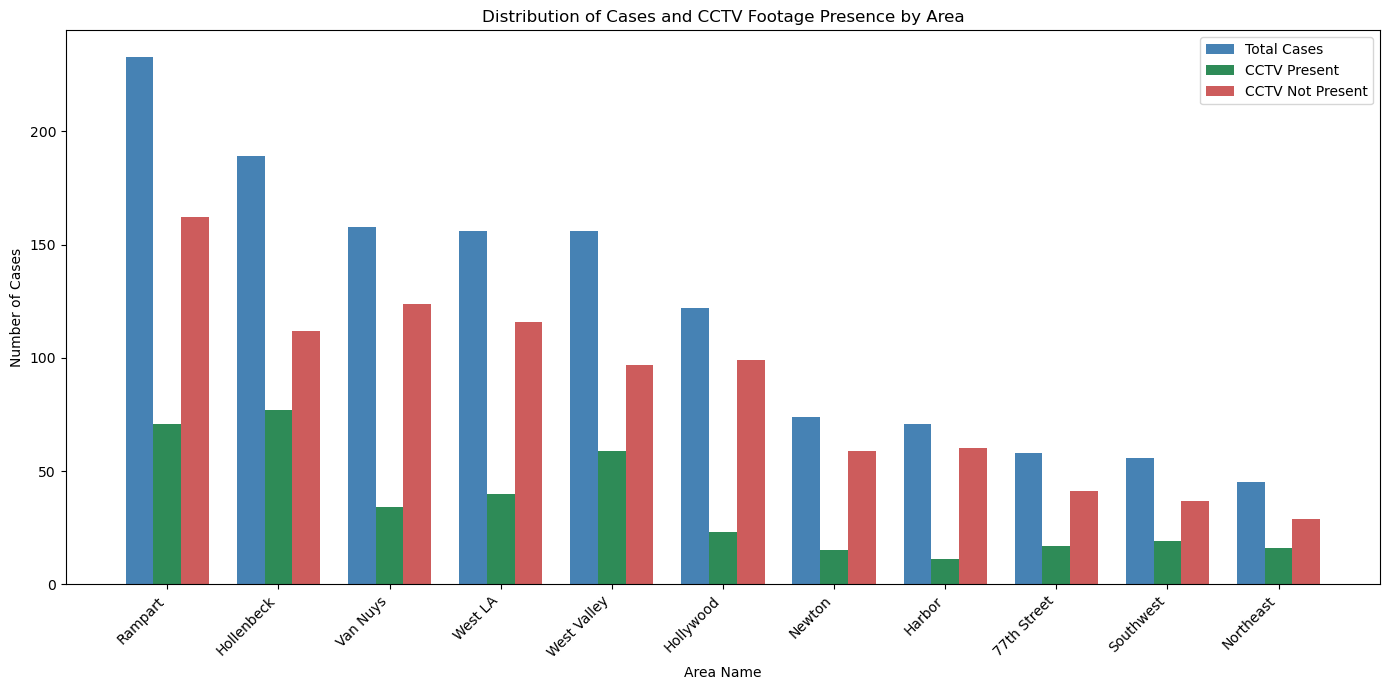

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
report_df = pd.read_csv("report_t.csv")
location_df = pd.read_csv("location_t.csv")

# Merge to get area_name
merged_df = report_df.merge(location_df[['area_code', 'area_name']], on='area_code', how='left')

# Group by area_name and cctv_flag to count cases with/without CCTV footage
cctv_counts = merged_df.groupby(['area_name', 'cctv_flag']).size().unstack(fill_value=0)

# Rename columns for clarity, assuming cctv_flag is 1 or 0
cctv_counts = cctv_counts.rename(columns={0: 'CCTV Not Present', 1: 'CCTV Present'})

# Add total cases column
cctv_counts['Total Cases'] = cctv_counts.sum(axis=1)

# Sort by total cases for better visualization
cctv_counts = cctv_counts.sort_values('Total Cases', ascending=False)

# Plotting
x = np.arange(len(cctv_counts))  # label locations
width = 0.25  # width of bars

fig, ax = plt.subplots(figsize=(14, 7))

bars_total = ax.bar(x - width, cctv_counts['Total Cases'], width, label='Total Cases', color='steelblue')
bars_present = ax.bar(x, cctv_counts['CCTV Present'], width, label='CCTV Present', color='seagreen')
bars_not_present = ax.bar(x + width, cctv_counts['CCTV Not Present'], width, label='CCTV Not Present', color='indianred')

# Labels and titles
ax.set_xlabel('Area Name')
ax.set_ylabel('Number of Cases')
ax.set_title('Distribution of Cases and CCTV Footage Presence by Area')
ax.set_xticks(x)
ax.set_xticklabels(cctv_counts.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


Unique offender relations: ['No' 'Yes']


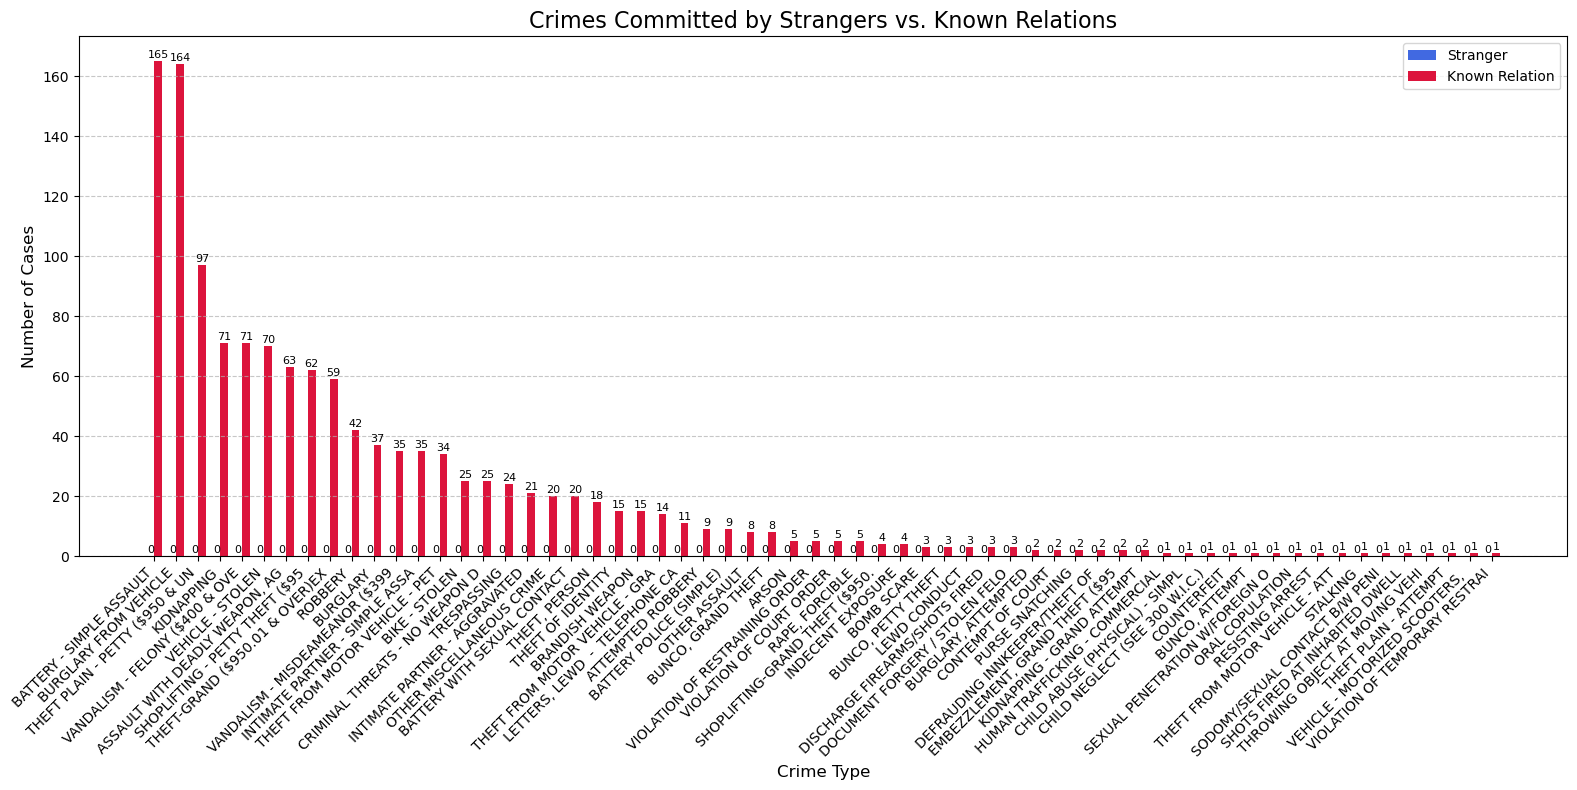

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the report_t.csv file
report_df = pd.read_csv('report_t.csv')

# Check unique values in offender_relation to understand the data
print("Unique offender relations:", report_df['offender_relation'].unique())

# Create a new column categorizing relations as "Stranger" or "Known Relation"
report_df['relation_category'] = report_df['offender_relation'].apply(
    lambda x: 'Stranger' if x == 'Stranger' else 'Known Relation'
)

# Count crimes by crime type and relation category
crime_by_relation = report_df.groupby(['crime_type', 'relation_category']).size().reset_index(name='count')

# Create a complete set of crime types and relation categories
all_crime_types = report_df['crime_type'].unique()
all_relations = ['Stranger', 'Known Relation']

# Create a MultiIndex with all combinations
multi_index = pd.MultiIndex.from_product([all_crime_types, all_relations], 
                                        names=['crime_type', 'relation_category'])

# Reindex to ensure all combinations exist
crime_by_relation = crime_by_relation.set_index(['crime_type', 'relation_category']).reindex(multi_index, fill_value=0).reset_index()

# Pivot the data for easier plotting
pivot_df = crime_by_relation.pivot(
    index='crime_type', 
    columns='relation_category', 
    values='count'
).fillna(0)

# Calculate total crimes per type to sort by overall frequency
pivot_df['total'] = pivot_df['Stranger'] + pivot_df['Known Relation']
pivot_df = pivot_df.sort_values('total', ascending=False).drop(columns=['total'])

# Create a grouped bar chart
plt.figure(figsize=(16, 8))

# Set the positions and width for the bars
pos = np.arange(len(pivot_df.index))
bar_width = 0.35

# Create the bars
plt.bar(pos, pivot_df['Stranger'], bar_width, label='Stranger', color='royalblue')
plt.bar(pos + bar_width, pivot_df['Known Relation'], bar_width, label='Known Relation', color='crimson')

# Add labels, title, and legend
plt.xlabel('Crime Type', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.title('Crimes Committed by Strangers vs. Known Relations', fontsize=16)
plt.xticks(pos + bar_width/2, pivot_df.index, rotation=45, ha='right')
plt.legend()

# Add value labels on top of each bar
for i in range(len(pivot_df)):
    plt.text(pos[i], pivot_df['Stranger'].iloc[i] + 0.5, 
             str(int(pivot_df['Stranger'].iloc[i])), ha='center', va='bottom', fontsize=8)
    plt.text(pos[i] + bar_width, pivot_df['Known Relation'].iloc[i] + 0.5, 
             str(int(pivot_df['Known Relation'].iloc[i])), ha='center', va='bottom', fontsize=8)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

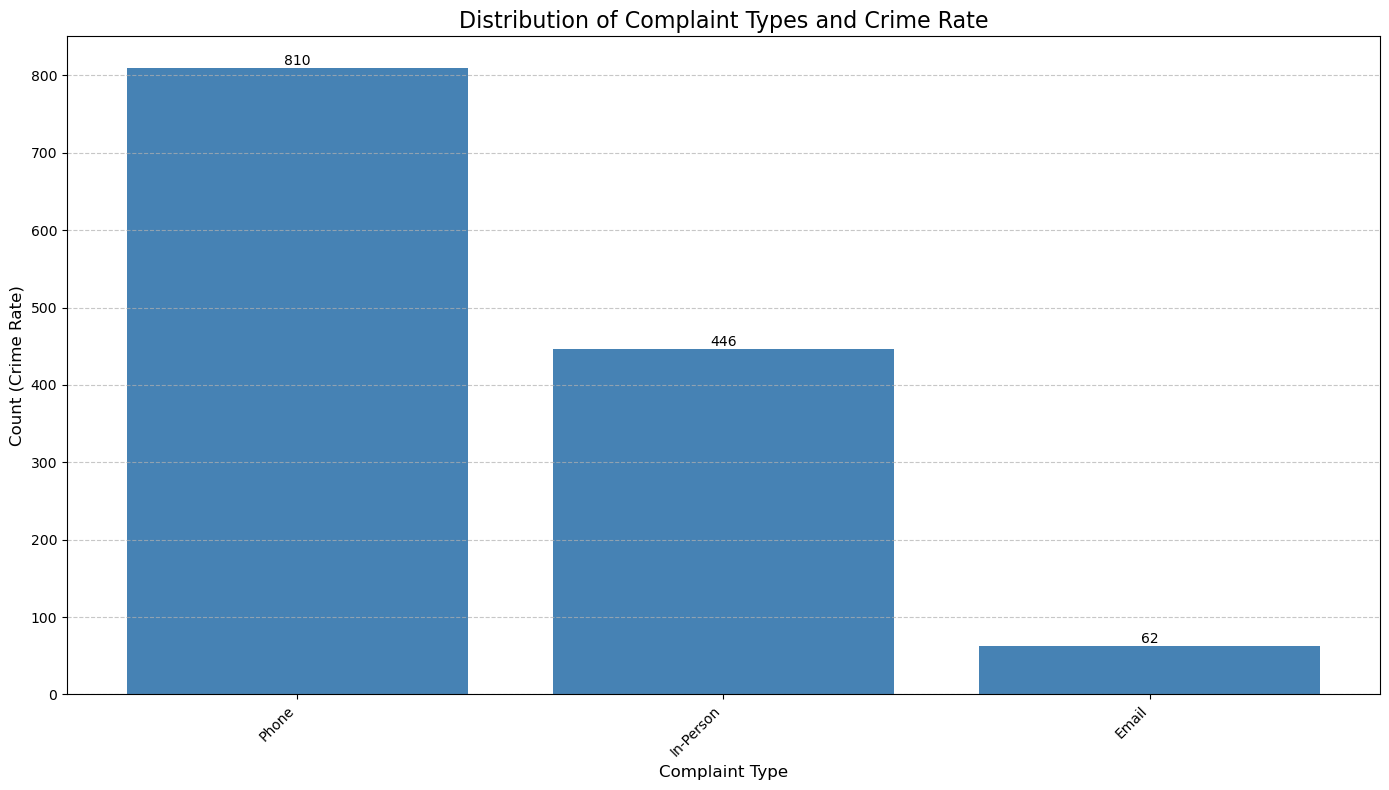

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the report_t.csv file
report_df = pd.read_csv('report_t.csv')

# Count the occurrences of each complaint type
complaint_counts = report_df['complaint_type'].value_counts().reset_index()
complaint_counts.columns = ['complaint_type', 'count']

# Sort by count in descending order
complaint_counts = complaint_counts.sort_values('count', ascending=False)

# Create a bar chart
plt.figure(figsize=(14, 8))
bars = plt.bar(complaint_counts['complaint_type'], complaint_counts['count'], color='steelblue')

# Add labels, title, and grid
plt.xlabel('Complaint Type', fontsize=12)
plt.ylabel('Count (Crime Rate)', fontsize=12)
plt.title('Distribution of Complaint Types and Crime Rate', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()